Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

In [1]:
!pip install -q gdown scikit-image patool torchinfo matplotlib numpy pandas IPython torch torchvision

### Importing all the important libraries

In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import json
import time
from IPython.display import display, clear_output
from skimage import io, transform

import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.transforms as T
from torchinfo import summary
from torch import flatten
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline

In [10]:
import gdown

file_id = "1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs"
output_file = "CNN_assignment.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From (original): https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs
From (redirected): https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs&confirm=t&uuid=5d36d311-2928-45bb-a45e-b0fe95d21cac
To: /content/CNN_assignment.zip
100%|██████████| 824M/824M [00:09<00:00, 83.7MB/s]


'CNN_assignment.zip'

In [14]:
!rm -rf 'Skin cancer ISIC The International Skin Imaging Collaboration'

In [15]:
import patoolib
patoolib.extract_archive("CNN_assignment.zip",outdir=".")

INFO patool: Extracting CNN_assignment.zip ...
INFO:patool:Extracting CNN_assignment.zip ...
INFO patool: running /usr/bin/7z x -o. -- CNN_assignment.zip
INFO:patool:running /usr/bin/7z x -o. -- CNN_assignment.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... CNN_assignment.zip extracted to `.'.
INFO:patool:... CNN_assignment.zip extracted to `.'.


'.'

In [16]:
LABELS = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

In [17]:
class CustomDataset(Dataset):
  def __init__(self, root, dirs=None, transform=None):

    self.root_dir = root
    self.sel_dirs = dirs
    self.transform = transform

    self.images = []
    self.labels = []
    self.__initItem()

  def __len__(self):
    if self.sel_dirs == None:
      return 0

    if len(self.images) == len(self.labels):
      return len(self.images)
    else:
      return 0

  def getImagesLabels(self):
    for (image, label) in zip(self.images, self.labels):
      print(f'{image} - {label}')

  def __checkDir(self, dirPath, images, labels, label=None):
    for f in os.listdir(dirPath):
      absDirPath = os.path.join(dirPath, f)

      if os.path.isdir(absDirPath):
        self.__checkDir(absDirPath, images, labels, f)
      elif os.path.isfile(absDirPath):
        images.append(absDirPath)
        labels.append(label)

    return (images, labels)

  def __initItem(self):
    images = []
    labels = []

    if self.sel_dirs == None:
      print(f'No selected directories')
      self.status = False
      return

    dirPath = os.path.join(self.root_dir, self.sel_dirs)
    print('path: ' + dirPath)

    if os.path.isdir(dirPath):
      self.__checkDir(dirPath, images, labels)
    else:
      print(f'Data which is not a folder found into selected directories')
      self.status = False
      return

    print('found ' + str(len(images)) + ' images and ' + str(len(labels)) + ' labels')

    self.images = images
    self.labels = labels

  def __getitem__(self, index):
    image = io.imread(self.images[index])
    label = torch.tensor(int(LABELS.index(self.labels[index])))

    if self.transform:
      image = self.transform(image)

    return (image, label)

In [18]:
normalize = T.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010])

transforms = T.Compose([
                          T.ToPILImage(),
                          T.Resize((224,224)),
                          # T.RandomHorizontalFlip(),
                          T.ToTensor(),
                          normalize
                        ])

training_dataset = CustomDataset(root="Skin cancer ISIC The International Skin Imaging Collaboration",
                          dirs="Train", transform=transforms)

test_dataset = CustomDataset(root="Skin cancer ISIC The International Skin Imaging Collaboration",
                          dirs="Test", transform=transforms)

path: Skin cancer ISIC The International Skin Imaging Collaboration/Train
found 2239 images and 2239 labels
path: Skin cancer ISIC The International Skin Imaging Collaboration/Test
found 118 images and 118 labels


In [19]:
print('How many images are in traning set?', len(training_dataset))
print('Labels: ', sorted(set(training_dataset.labels)))

How many images are in traning set? 2239
Labels:  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [20]:
num_classes = 9
num_epochs = 20
batch_size = 32
learning_rate = 1e-3
random_seed=42
valid_size=0.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
num_train = len(training_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=batch_size, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=batch_size, sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

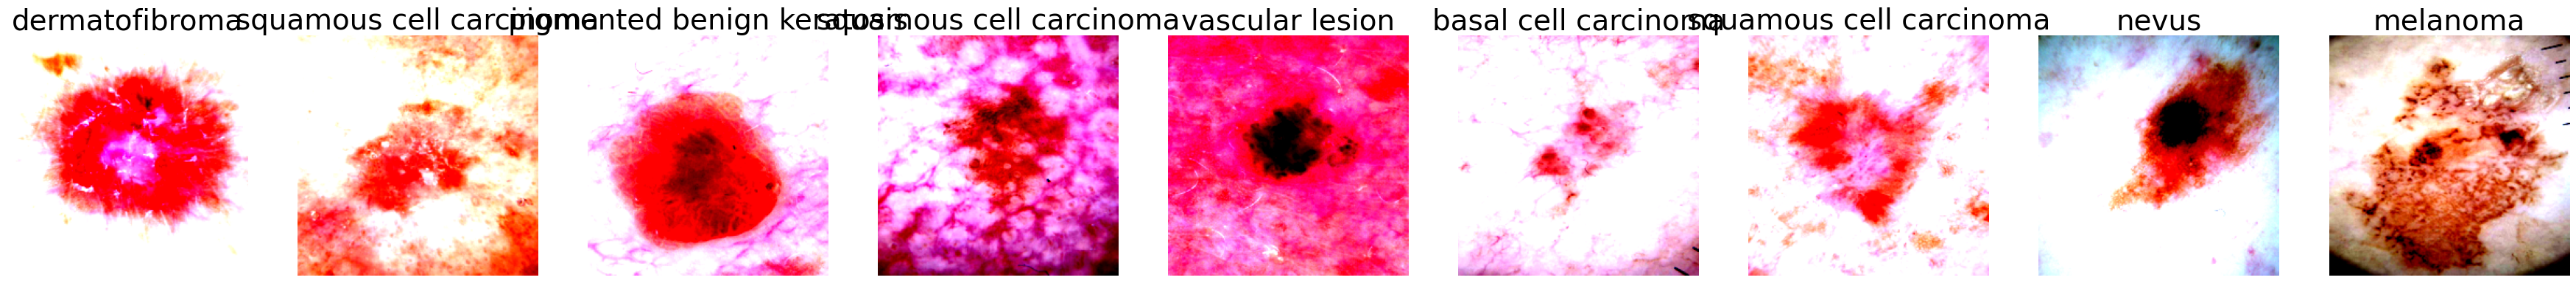

In [22]:
how_many_to_plot = 9

batch = next(iter(train_loader))


plt.figure(figsize=(50,50))
for i, batch in enumerate(train_loader, start=1):
    image, label = batch
    plt.subplot(10, 10, i)
    plt.imshow(image[0, :].permute(2, 1, 0))
    plt.axis('off')
    plt.title(LABELS[label[0].item()], fontsize=28)
    if (i >= how_many_to_plot):
        break

plt.show()

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [23]:
class VGG16(nn.Module):
    def __init__(self, num_classes=9):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = VGG16(num_classes).to(device)

summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG16                                    [1, 9]                    --
├─Sequential: 1-1                        [1, 64, 224, 224]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         128
│    └─ReLU: 2-3                         [1, 64, 224, 224]         --
├─Sequential: 1-2                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 64, 224, 224]         36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 224, 224]         128
│    └─ReLU: 2-6                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-7                    [1, 64, 112, 112]         --
├─Sequential: 1-3                        [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 112, 112]        256
│

In [24]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Train the model
train_total_step = len(train_loader)
valid_total_step = len(valid_loader)

In [25]:
res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    train_loss, train_correct, train_total = 0, 0, 0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        train_correct += correct
        train_total += labels.size(0)

        #print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{train_total_step}], Acc: {correct}, Loss: {loss.item():.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}] - Training loss: {train_loss/train_total_step:.4f}, Training accuracy ({train_total} training images): {100 * train_correct/train_total:.2f}%')
    res['train_loss'].append(train_loss/train_total_step)
    res['train_acc'].append(100 * train_correct/train_total)


    # Validation
    with torch.no_grad():
        val_correct, val_loss, val_total = 0, 0, 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print(f'Epoch [{epoch+1}/{num_epochs}] - Validation loss: {val_loss/valid_total_step:.4f}, Validation accuracy ({val_total} validation images): {100 * val_correct / val_total:.2f} %')

        res['val_loss'].append(val_loss/valid_total_step)
        res['val_acc'].append(100 * val_correct/val_total)

Epoch [1/20] - Training loss: 4.6462, Training accuracy (2016 training images): 25.79%
Epoch [1/20] - Validation loss: 1.8213, Validation accuracy (223 validation images): 37.22 %
Epoch [2/20] - Training loss: 1.8098, Training accuracy (2016 training images): 35.42%
Epoch [2/20] - Validation loss: 1.9318, Validation accuracy (223 validation images): 33.18 %
Epoch [3/20] - Training loss: 1.6960, Training accuracy (2016 training images): 41.96%
Epoch [3/20] - Validation loss: 1.7047, Validation accuracy (223 validation images): 41.70 %
Epoch [4/20] - Training loss: 1.6229, Training accuracy (2016 training images): 42.71%
Epoch [4/20] - Validation loss: 1.6571, Validation accuracy (223 validation images): 40.36 %
Epoch [5/20] - Training loss: 1.5736, Training accuracy (2016 training images): 45.49%
Epoch [5/20] - Validation loss: 1.6189, Validation accuracy (223 validation images): 43.95 %
Epoch [6/20] - Training loss: 1.5979, Training accuracy (2016 training images): 44.05%
Epoch [6/20] 

In [26]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')

Accuracy of the network on the 118 test images: 24.576271186440678 %


### Visualizing training results

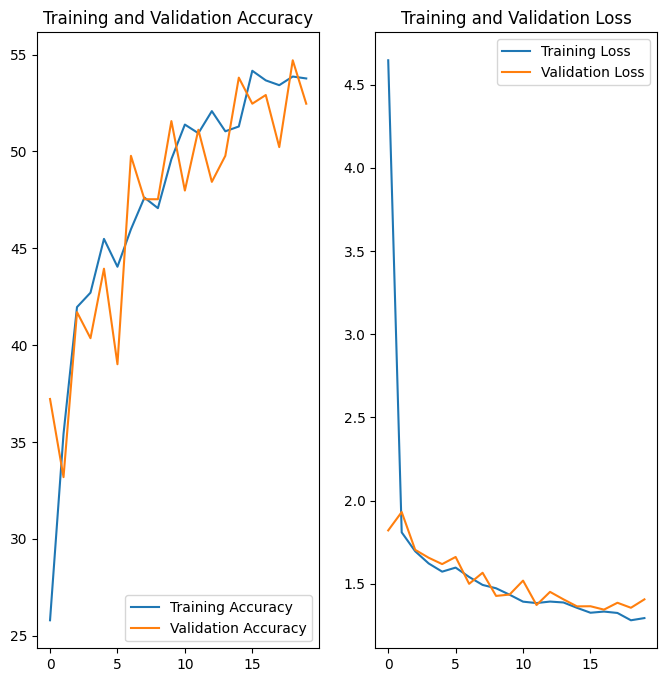

In [27]:
acc = res['train_acc']
val_acc = res['val_acc']

loss = res['train_loss']
val_loss = res['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()